In [142]:
# load libraries
library(shiny)
library(dplyr)
library(ggplot2)

ERROR: Error in library(dplyr): there is no package called ‘dplyr’


In [143]:
#read data
data = read.csv("data/ad_table.csv")
dim(data)

data$date  <- as.Date(data$date)                     #convert date to R date type
# create days in study
data$day   <- as.numeric( data$date - min(data$date) +1)
# create some hypothetical test group variable 
data$group   <-  as.numeric(substr(data$ad, 10, 12))
# drop variables not useful
# drops <- c("ad","grp")
# data <- data[ , !(names(data) %in% drops)]
# look at the first few lines of data

# order data first by group then by day
data <- data[order(data$group,data$date),]

# calculate the cumulated clicked and cumulated converted
data$cum_clicked <- sapply(1:nrow(data),  
                           function(i)    sum((data[1:i, c("group")] == data$group[i]) * data[1:i,]$clicked) )

data$cum_converted <- sapply(1:nrow(data),  
                           function(i)    sum((data[1:i, c("group")] == data$group[i]) * data[1:i,]$converted) )
                               
data$CR = data$cum_converted  / data$cum_clicked *100

head(data)   

[1] 2115    7

date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,day,group,cum_clicked,cum_converted,CR
2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,1,1,2339,43,1.838392
2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,2,1,4837,81,1.674592
2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,3,1,7150,130,1.818182
2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,4,1,9983,181,1.813082
2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,5,1,12679,222,1.750927
2015-10-06,66864,2617,46,0.98,746.48,ad_group_1,6,1,15296,268,1.752092


Start with only 2 groups, say default and test groups:

In [151]:
data12 <- data[data$group <=2, ]
dim(data12)

max_day = as.numeric(max(data$date)- min(data$date)) ; max_day

[1] 106  12

[1] 52

In [179]:
days = 3
alpha = 1
beta  = 1  
bayes_result <- function(days, alpha =1, beta=1 ){
    
    n_total1 = data[data$day == days & data$group==1 , 'cum_clicked']    
    n_total2 = data[data$day == days & data$group==2 , 'cum_clicked']  
    n_conv1  = data[data$day == days & data$group==1 , 'cum_converted'] 
    n_conv2  = data[data$day == days & data$group==2 , 'cum_converted'] 

    # compute prior, pooled likehood and posteriors for male and female:
    theta <-seq(0,1,0.001) #create theta range from 0 to 1
    prior <- dbeta(theta, alpha, beta)

    likelihood1 <- dbinom(n_conv1, size= n_total1 , prob= theta)   
    likelihood2 <- dbinom(n_conv2, size= n_total2 , prob= theta)   

    posterior_1 <- dbeta(theta, alpha + n_conv1, beta + n_total1 - n_conv1 ) 
    posterior_2 <- dbeta(theta, alpha + n_conv2, beta + n_total2 - n_conv2 ) 


    p05_1  = qbeta(p = 0.05, shape1 = alpha + n_conv1 , shape2 = beta + n_total1 - n_conv1, lower.tail = TRUE) 
    p95_1  = qbeta(p = 0.95, shape1 = alpha + n_conv1 , shape2 = beta + n_total1 - n_conv1, lower.tail = FALSE) 
    p05_2  = qbeta(p = 0.05, shape1 = alpha + n_conv2 , shape2 = beta + n_total2 - n_conv2, lower.tail = TRUE) 
    p95_2  = qbeta(p = 0.95, shape1 = alpha + n_conv2 , shape2 = beta + n_total2 - n_conv2, lower.tail = FALSE) 
    
    return n_total1, n_total2, n_conv1 , n_conv2 
    }

ERROR: Error in parse(text = x, srcfile = src): <text>:27:12: unexpected symbol
26:     
27:     return n_total1
               ^


In [178]:
bayes_result(days= 3)

ERROR: Error in return[n_total1, n_total2, n_conv1, n_conv2]: object of type 'special' is not subsettable


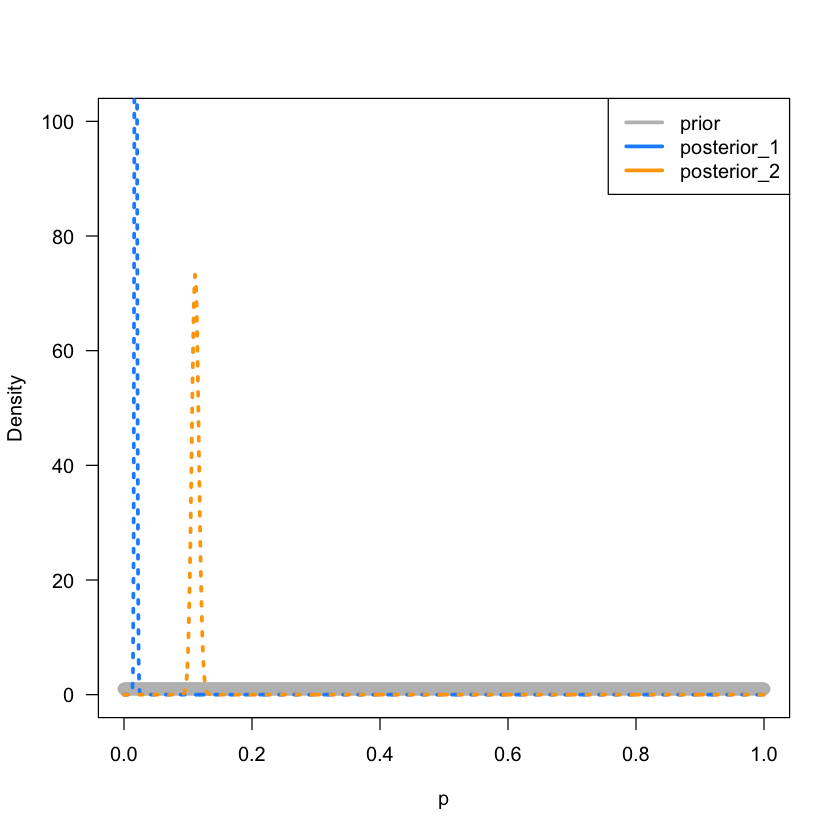

In [152]:
#plot of probabilities
plot(theta, prior, lwd = 3, col="gray", lty=2 , xlab = bquote(p), ylab = "Density", las = 1, ylim = c(0,100))#, xlim=c(0,0.2))
#lines(theta, likelihood1, lwd = 3,type = "l", col="pink")
#lines(theta, likelihood2, lwd = 3,type = "l", col="purple")
lines(theta, posterior_1, lwd = 3, col="dodgerblue", lty=3)
lines(theta, posterior_2, lwd = 3, col="orange", lty=3)
legend("topright",lwd=3,
   c("prior","posterior_1","posterior_2"),
   col = c("grey","dodgerblue","orange")
   )

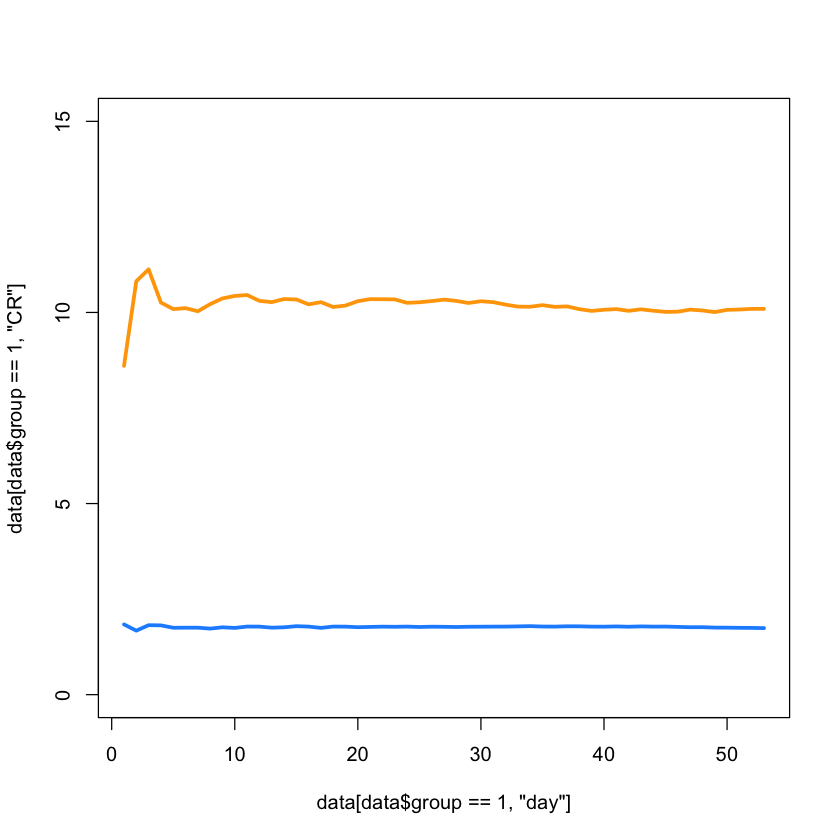

In [146]:
plot( data[data$group==1, 'day'], data[data$group==1, 'CR'] ,type = "l", lwd = 3, col="dodgerblue", lty=1, ylim = c(0,15))
lines(data[data$group==1, 'day'], data[data$group==2, 'CR'] ,type = "l", lwd = 3, col="orange", lty=1)


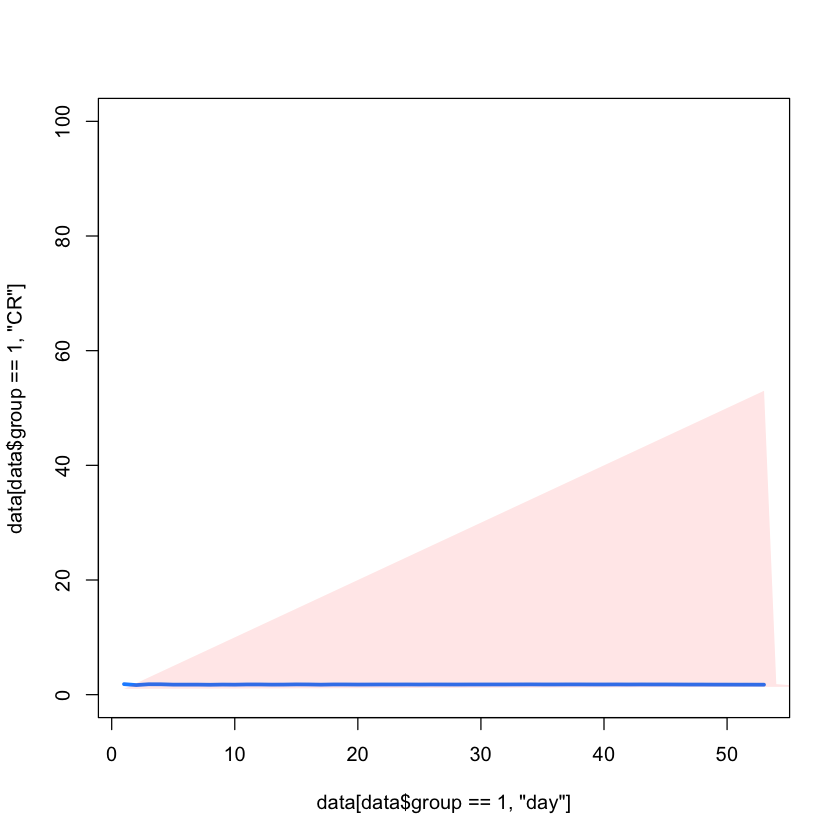

In [174]:
data1= data12[data12$group==1, ]
plot( data[data$group==1, 'day'], data[data$group==1, 'CR'] ,type = "l", lwd = 3, col="dodgerblue", lty=1, ylim = c(0,100))
polygon(c(data1$day , data1$CR ),c(data1$q05_1,data1$q95_1), col=rgb(1, 0, 0,0.1),border=NA)




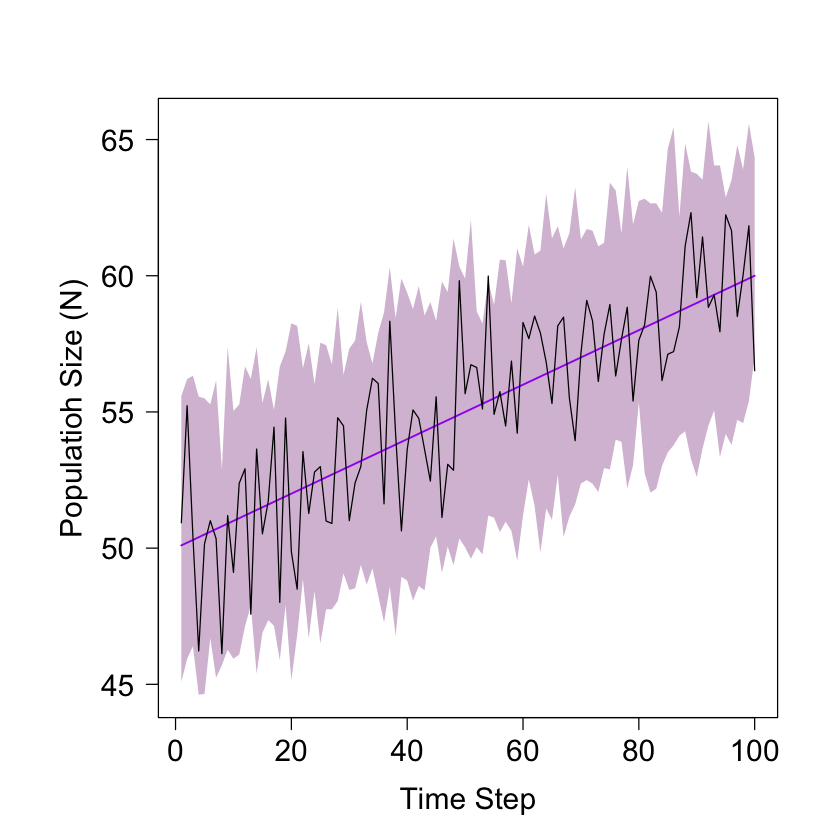

In [134]:
par.default <- par(no.readonly=TRUE)
par(mar=c(5,6,4,2)+0.1)
par(pty="s")

# create data
x <- 1:100
Exp <- 50 + x*0.1
Con.High <- Exp + 5 + rnorm(100)
Con.Low <- Exp - 5 + rnorm(100)
One.Run <- Exp + rnorm(100,0,2)

# create plot
plot(Exp~x,type="l",
     xlab= "Time Step",
     ylab="Populatioh Size (N)",
     lty="dashed",
     ylim=range(One.Run,Exp,Con.High,Con.Low),
     cex.lab=1.5,las=1,cex.axis=1.5)

# add polygon and overlplot the lines
polygon(c(x,rev(x)),c(Con.Low,rev(Con.High)),col="thistle",border=NA)
lines(x,Exp,lty="solid",col="purple",lwd=1.5)
lines(x,One.Run)


par(par.default)
rm(list=ls())